In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.utils.data as dataset
import sklearn
from sklearn.metrics import r2_score

In [2]:
"""
Functions to process the data
"""

def data2tensor(seq,energy):
    
    """
    convert the sequence to one-hot vector
    """

    matrix = np.zeros([len(seq),4])
    for id,base in enumerate(seq):
        if base == 'G':
            matrix[id,0] = 1
        elif base == 'C':
            matrix[id,1] = 1
        elif base == 'A':
            matrix[id,2] = 1
        elif base =='U':
            matrix[id,3] = 1
        else:
            print("error1")
    
    #reshape it into single vector
    
    matrix = torch.from_numpy(matrix).float()
    
    tensor_energy = torch.from_numpy(np.array(energy)).float()
    
    return(matrix,tensor_energy)


def data2Image(seq,energy):
    
    """
    convert the sequence to one-hot vector
    """

    matrix = np.zeros([1,len(seq),4])
    for id,base in enumerate(seq):
        if base == 'G':
            matrix[0,id,0] = 1
        elif base == 'C':
            matrix[0,id,1] = 1
        elif base == 'A':
            matrix[0,id,2] = 1
        elif base =='U':
            matrix[0,id,3] = 1
        else:
            print("error1")
    
    #reshape it into single vector
    
    matrix = torch.from_numpy(matrix).float()
    
    tensor_energy = torch.from_numpy(np.array(energy)).float()
    
    return(matrix,tensor_energy)

def data_processing(data,dimension = 2):
    
    if dimension ==2:
        DNA_seq = torch.zeros([data.shape[0],30,4])
        DNA_energy = torch.zeros([data.shape[0],1])

        for index in range(data.shape[0]):
            seq_info = data['seq'][index]
            energy = data['energy'][index]
            DNA_seq[index],DNA_energy[index] = data2tensor(seq_info,energy)
    
    elif dimension ==3:
        DNA_seq = torch.zeros([data.shape[0],1,30,4])
        DNA_energy = torch.zeros([data.shape[0],1])

        for index in range(data.shape[0]):
            seq_info = data['seq'][index]
            energy = data['energy'][index]
            DNA_seq[index],DNA_energy[index] = data2Image(seq_info,energy)

    split  = 0.8
    batch_size = 100
    split_index = int(data.shape[0]*0.8)

    training_data_set = dataset.TensorDataset(DNA_seq[0:split_index],DNA_energy[0:split_index])
    testing_data_set = dataset.TensorDataset(DNA_seq[split_index+1:data.shape[0]],DNA_energy[split_index+1:data.shape[0]])

    training_data_loader = dataset.DataLoader(training_data_set,batch_size,shuffle = True)
    testing_data_loader = dataset.DataLoader(testing_data_set,1000,shuffle = True)
    return(training_data_loader,testing_data_loader)

# Construct the deep neural net model

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.layer1 = nn.Linear(120,100)
        #self.drop_out = nn.Dropout()    
        self.layer2 = nn.Linear(100,10)
        self.predict = nn.Linear(10,1)
        
    def forward(self,x):
        x = F.relu(self.layer1(x))
        #x = self.dropout(x) 
        x = F.relu(self.layer2(x))
        x = self.predict(x)
        
        return(x)

In [4]:
class ConvNet(nn.Module):   
    
    def __init__(self):      
        super(ConvNet,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1))
        
        #self.drop_out = nn.Dropout()
        
        self.fc1 = nn.Linear(1 * 56 * 10, 50)
        self.fc2 = nn.Linear(50, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        #out = self.drop_odata = pd.read_csv('nupack_generate.csv')ut(out)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
    
        return out

In [5]:
def training(training_data_loader,testing_data_loader,epochs = 500,learning_rate = 0.01,model = 'DNN'):
    
    loss_epoch = np.zeros(epochs)
    R_squre = np.zeros(epochs)
    
    if model=='DNN':
        print('Deep Neural network is chosed: 120 features, layer1: 100 node, layer2:10')
        model = Net()
        optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)
        loss_func = torch.nn.MSELoss()

        loss_epoch = np.zeros(epochs)
        R_squre = np.zeros(epochs)
        for epcho in range(epochs):
            for step, (DNA_seq_2D,DNA_energy) in enumerate(training_data_loader):
                DNA_seq_flatten = DNA_seq_2D.view(DNA_seq_2D.shape[0],-1)

                outputs = model(DNA_seq_flatten)
                loss = loss_func(outputs, DNA_energy)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if epcho%50 ==0:
                print('Epoches: %d, Loss = %.8f'%(epcho,loss.data.numpy()))
            R_squre[epcho] = r2_score(outputs.detach().numpy(),DNA_energy.detach().numpy())
            loss_epoch[epcho] = loss.data.numpy()
            
            
            real_energy = []
            predicted_energy = []

            for index_id, (DNA_seq_test,DNA_energy_test) in enumerate(testing_data_loader):
                DNA_test_flaten = DNA_seq_test.view(DNA_seq_test.shape[0],-1)
                predict = model(DNA_test_flaten)
                predict_energy = predict.detach().numpy()
                real_energy = DNA_energy_test.detach().numpy()

            
    elif model == 'CNN':
        print('Convelutional Neural network is chosed: ')
        model = ConvNet()
        # Loss and optimizer
        loss_function = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
        for epcho in range(epochs):
            for step, (DNA_seq_2D,DNA_energy) in enumerate(training_data_loader):

                outputs = model(DNA_seq_2D)
                loss = loss_function(outputs, DNA_energy)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if epcho%50 ==0:
                print('Epoches: %d, Loss = %.8f'%(epcho,loss.data.numpy()))
            loss_epoch[epcho] = loss.data.numpy()
            
        real_energy = []
        predicted_energy = []
        for index_id, (DNA_seq_test,DNA_energy_test) in enumerate(testing_data_loader):
            predict = model(DNA_seq_test)
            predict_energy = predict.detach().numpy()
            real_energy = DNA_energy_test.detach().numpy()
            
    else:
        print("Error:The model is not available...\n")

    plt.plot()
    plt.plot(loss_epoch)
    plt.xlabel('Training Epoches')
    plt.ylabel('Loss')
    plt.savefig('training.jpeg')
    
    print('### The model final resutls is %.8f'%r2_score(predict_energy,real_energy))

# Load the data

In [6]:
data = pd.read_csv("nupack_generate.csv")

# Training a deep neural network

In [ ]:
training_data_loader,testing_data_loader = data_processing(data,dimension=2)
training(training_data_loader,testing_data_loader,epochs=200,learning_rate=0.001,model='DNN')

Deep Neural network is chosed: 120 features, layer1: 100 node, layer2:10
Epoches: 0, Loss = 1.18401825
Epoches: 50, Loss = 0.12957625
Epoches: 100, Loss = 0.14266068


Convelutional Neural network is chosed: 
Epoches: 0, Loss = 4.29183960
Epoches: 50, Loss = 0.27054322
Epoches: 100, Loss = 0.25987315
Epoches: 150, Loss = 0.14137004
### The model final resutls is 0.99582947


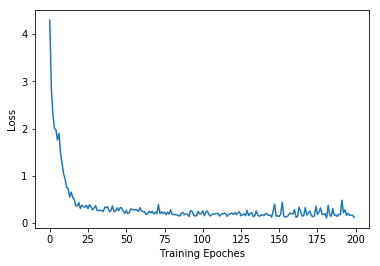

In [115]:
training_data_loader,testing_data_loader = data_processing(data,dimension=3)
training(training_data_loader,testing_data_loader,epochs=200,learning_rate=0.0001,model='CNN')